In [1]:
# Mount the Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from numpy import load
import matplotlib.pyplot as plt

# Load npz training dataset
data = load('/content/drive/MyDrive/Colab Notebooks/DH Project/cat2tattoo_256.npz')
dataA = data['arr_0']
dataB = data['arr_1']
print('Loaded:', dataA.shape, dataB.shape)

Loaded: (1648, 256, 256, 3) (1678, 256, 256, 3)


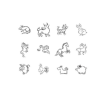

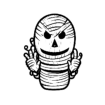

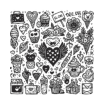

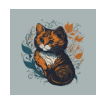

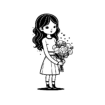

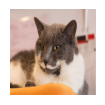

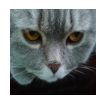

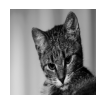

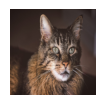

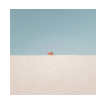

In [8]:
# Plot source image

n_samples = 5
for i in range(n_samples):
  plt.subplot(2, n_samples, 1)
  plt.imshow(dataB[i].astype('uint8'))
  plt.axis('off')
  plt.show()

# Plot target image

for i in range(n_samples):
  plt.subplot(2, n_samples, 1)
  plt.axis('off')
  plt.imshow(dataA[i].astype('uint8'))
  plt.show()

In [9]:
# Install keras-contrib library to get instance normalization

# Unlike other models, the CycleGAN discriminator uses InstanceNormalization instead of BatchNormalization

!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-vsd9k8wt
  Running command git clone --filter=blob:none --quiet https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-vsd9k8wt
  Resolved https://www.github.com/keras-team/keras-contrib.git to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0
  Preparing metadata (setup.py) ... done
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101055 sha256=e0e198b229d293325bee493f156bd3c512389aad358c852e4e2f442465d5f67d
  Stored in directory: /tmp/pip-ephem-wheel-cache-e0vcrm8d/wheels/74/d5/f7/0245af7ac33d5b0c2e095688649916e4bf9a8d6b3362a849f5
Successfully built keras-contrib


In [10]:
# Import libraries
from random import random
import numpy as np
import matplotlib.pyplot as plt
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from matplotlib import pyplot
import os
import tensorflow as tf

In [11]:
# Define Discriminator model

def define_discriminator(image_shape):

  # Weight initialization
  weight = RandomNormal(stddev = 0.02)

  # Source image input
  in_image = Input(shape = image_shape)

  # Convolutional 64
  d = Conv2D(64, (4,4), strides = (2,2), padding = 'same', kernel_initializer = weight)(in_image)
  d = LeakyReLU(alpha = 0.2)(d)

  # Unlike the standard ReLU activation, which sets all negative values to zero, LeakyReLU allows a small, non-zero gradient (alpha) when the unit is not active and the input is less than zero,
  # help mitigate the vanishing gradient problem during training.

  # Convolutional 128
  d = Conv2D(128, (4,4), strides = (2,2), padding = 'same', kernel_initializer = weight)(d)
  d = InstanceNormalization(axis = -1)(d)
  d = LeakyReLU(alpha = 0.2)(d)

  # InstanceNormalization normalizes the data within each example in the batch, maintaining a consistent distribution of values across the feature maps.

  # Conviolutional 256
  d = Conv2D(256, (4,4), strides = (2,2), padding = 'same', kernel_initializer = weight)(d)
  d = InstanceNormalization(axis = -1)(d)
  d = LeakyReLU(alpha = 0.2)(d)

  # Conviolutional 512
  d = Conv2D(512, (4,4), strides = (2,2), padding = 'same', kernel_initializer = weight)(d)
  d = InstanceNormalization(axis = -1)(d)
  d = LeakyReLU(alpha = 0.2)(d)

  # second last output layer
  d = Conv2D(512, (4,4), padding='same', kernel_initializer = weight)(d)
  d = InstanceNormalization(axis=-1)(d)
  d = LeakyReLU(alpha=0.2)(d)

  # Patch output (The output of this layer is a single-channel feature map, but this map can contain multiple values, not just one.
  #               Each of these values corresponds to a different region (or "patch") of the input image)

  patch_out = Conv2D(1, (4,4), padding = 'same', kernel_initializer = weight)(d)

  # Define model
  model = Model(in_image, patch_out)

  # Compile model

  model.compile(loss = 'mse', optimizer = Adam(learning_rate = 0.0002, beta_1 = 0.5), loss_weights = [0.5])

  return model

In [12]:
# Build ResNet block for Generator to decode the bottleneck layer after encoding the input image

def resnet_block(n_filters, input_layer):

  # Weight Initialization
  weight = RandomNormal(stddev = 0.2)

  # First Conv layer
  g = Conv2D(n_filters, (3,3), padding = 'same', kernel_initializer = weight)(input_layer)
  g = InstanceNormalization(axis = -1)(g)
  g = Activation('relu')(g)

  # Second Conv layer
  g = Conv2D(n_filters, (3,3), padding = 'same', kernel_initializer = weight)(g)
  g = InstanceNormalization(axis = -1)(g)

  # Concatenate channel-wise with the input layer
  g = Concatenate()([g, input_layer])

  return g

In [13]:
# Define standalone Generator model

def define_generator(image_shape, n_resnet = 9):

  # Weight Initialization
  weight = RandomNormal(stddev = 0.2)

  # Image input
  in_image = Input(shape = image_shape)

  # C64
  g = Conv2D(64, (7,7), padding = 'same', kernel_initializer = weight)(in_image)
  g = InstanceNormalization(axis = -1)(g)
  g = Activation('relu')(g)

  # C128
  g = Conv2D(128, (3,3), strides = (2,2), padding = 'same', kernel_initializer = weight)(g)
  g = InstanceNormalization(axis = -1)(g)
  g = Activation('relu')(g)

  # C256
  g = Conv2D(256, (3,3), strides = (2,2), padding = 'same', kernel_initializer = weight)(g)
  g = InstanceNormalization(axis = -1)(g)
  g = Activation('relu')(g)

  # ResNet 256
  for i in range(n_resnet):
    g = resnet_block(256, g)

  # DeConvolution 128
  g = Conv2DTranspose(128, (3,3), strides = (2,2), padding = 'same', kernel_initializer = weight)(g)
  g = InstanceNormalization(axis = -1)(g)
  g = Activation('relu')(g)

  # DeConvolution 64
  g = Conv2DTranspose(64, (3,3), strides = (2,2), padding = 'same', kernel_initializer = weight)(g)
  g = InstanceNormalization(axis = -1)(g)
  g = Activation('relu')(g)

  # C3
  g = Conv2D(3, (7,7), padding = 'same', kernel_initializer = weight)(g)
  g = InstanceNormalization(axis = -1)(g)
  out_image = Activation('tanh')(g)

  # Define mode
  model = Model(in_image, out_image)

  return model


In [14]:
# Define a composite model for updating generators by adversarial and cycle loss

def define_composite_model(g_model_1, d_model, g_model_2, image_shape):

  # Ensure the Generator 1 is trainable
  g_model_1.trainable = True

  # Mark Discriminator as not trainable
  d_model.trainable = False

  # Mark other Generator as not trainable
  g_model_2.trainable = False

  # Discriminator Element
  input_gen = Input(shape = image_shape) # Input from domain 2
  gen1_out = g_model_1(input_gen) # go through Generator 1 to achieve translation to domain 1
  output_d = d_model(gen1_out) # Discriminator judges this picture

  # Identity element (feed image from target domain to the Generator and it should not alter the image -> minimize the identity loss)
  input_id = Input(shape = image_shape) # Input from domain 1
  output_id = g_model_1(input_id) # go through Gen 1 to minimalize identity loss

  # Forward cycle
  output_f = g_model_2(gen1_out) # picture translated to Domain 1 is now the input for Generator 2. Output should resemble input_gen

  # Backward cycle
  gen2_out = g_model_2 (input_id)
  output_b = g_model_1 (gen2_out)

  # Define model graph
  model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])

  # Define optimization configuration
  opt = Adam(learning_rate = 0.0002, beta_1 = 0.5)

  # Compile model with weighting of least squares loss and L1 loss
  model.compile(loss = (['mse', 'mae', 'mae', 'mae']), loss_weights = [1,5,10,10], optimizer = opt)

  return model

In [15]:
# Load and prepare training images
def load_real_samples(filename):

  # Load dataset
  data = load(filename)

  # Unpack data
  X1 = data['arr_0']
  X2 = data['arr_1']

  # Scale image
  X1 = (X1 - 127.5) / 127.5
  X2 = (X2 - 127.5) / 127.5

  return [X1, X2]

In [17]:
# Function to generate real samples from the datasets
def generate_real_samples(dataset, n_samples, patch_shape):

  # choose random instances
  ix = randint(0, dataset.shape[0], n_samples)

  # Retrieve selected images
  X = dataset[ix]

  # Create real class label
  y = ones((n_samples, patch_shape, patch_shape, 1)) # preparing a batch of labels indicating that every patch in every image is "real", 1 dimension

  return X, y

In [18]:
# Function for the Generator to generate fake samples
def generate_fake_samples(g_model, dataset, patch_shape):

  # generate fake instances
  X = g_model.predict(dataset)

  # Create fake class labels
  y = zeros((len(X), patch_shape, patch_shape, 1))

  return X, y

In [19]:
# Save models for future use
def save_models(step, g_model_AtoB, g_model_BtoA):

  # Specify the path to your folder in Google Drive
  drive_folder = '/content/drive/MyDrive/Colab Notebooks/DH Project/Trained models/'

  # Make sure the folder exists, and if not, create it
  os.makedirs(drive_folder, exist_ok=True)

  # Define the filenames with a .tf extension indicating the TensorFlow SavedModel format
  filename1 = f"{drive_folder}g_model_AtoB_{step+1:06d}"
  filename2 = f"{drive_folder}g_model_BtoA_{step+1:06d}"

  # Save the first Generator model in TensorFlow SavedModel format
  tf.saved_model.save(g_model_AtoB, filename1)

  # Save the second Generator model in TensorFlow SavedModel format
  tf.saved_model.save(g_model_BtoA, filename2)

  print(f'>Saved: {filename1, filename2}')

In [20]:
# Generate samples and save as a plot and save the model

def summarize_performance(step, g_model, trainX, name, n_samples = 5):

  # Select a sample of input image
  X_in, _ = generate_real_samples(trainX, n_samples, 0)

  # Generate translated image
  X_out, _ = generate_fake_samples(g_model, X_in, 0)

  # Scale pixels from [-1,1] to [0,1]
  X_in = (X_in + 1) / 2.0
  X_out = (X_out + 1) / 2.0

  # Plot real image
  for i in range(n_samples):
    plt.subplot(2, n_samples, 1 + i)
    plt.axis('off')
    plt.imshow(X_in[i])

  # Plot translated image
  for i in range(n_samples):
    plt.subplot(2, n_samples, 1 + n_samples + i)
    plt.axis('off')
    plt.imshow(X_out[i])

  # Specify the folder path in Google Drive
  drive_folder = '/content/drive/MyDrive/Colab Notebooks/DH Project/Trained images/'

  os.makedirs(drive_folder, exist_ok=True)  # Ensure the folder exists

  # Save plot to file
  filename = f"{drive_folder}{name}_generated_plot_{step+1:06d}.png"
  plt.savefig(filename)
  plt.close()
  print(f">Saved: {filename}")

In [21]:
# Update image pool for fake images

def update_image_pool(pool, images, max_size = 50):

  selected = []

  for image in images:

    # Add to the image pool and selected list if list length has not exceeded max size
    if len(pool) < max_size:
      pool.append(image)
      selected.append(image)

    # Once the pool reaches max size, if random returns a number < 0.5, then use the image but don't add it to the pool, prevent overfitting
    elif random() < 0.5:
      selected.append(image)

    # Otherwise, replace an existing image and use replaced image
    else:
      ix = randint(0, len(pool))
      selected.append(pool[ix])
      pool[ix] = image

  return asarray(selected)

In [22]:
# Train Cycle - GAN model

def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset):

  # Define properties of the training run
  n_epochs = 50 # Can increase this
  n_batch = 1

  # Determine the output square shape of the Discriminator
  n_patch = d_model_A.output_shape[1]

  # Unpack dataset
  trainA, trainB = dataset

  # Prepare image pool for fake images
  poolA = []
  poolB = []

  # Calculate the number of batches per training epoch
  bat_per_epo = int(len(trainA) / n_batch)

  # Calculate the number of training iterations
  n_steps = bat_per_epo * n_epochs

  # Enumerate epochs
  for i in range(n_steps):

    # Select a batch of real images
    X_real_A, y_real_A = generate_real_samples(trainA, n_batch, n_patch)
    X_real_B, y_real_B = generate_real_samples(trainB, n_batch, n_patch)

    # Select a batch of fake images
    X_fake_A, y_fake_A = generate_fake_samples(g_model_BtoA, X_real_B, n_patch)
    X_fake_B, y_fake_B = generate_fake_samples(g_model_AtoB, X_real_A, n_patch)

    # Update fakes from pool
    X_fake_A = update_image_pool(poolA, X_fake_A)
    X_fake_B = update_image_pool(poolB, X_fake_B)

    # Update Generator B->A via adversarial and cycle loss
    g_loss_2, _, _, _, _  = c_model_BtoA.train_on_batch([X_real_B, X_real_A], [y_real_A, X_real_A, X_real_B, X_real_A])

    # Update Discriminator for A -> [real/fake]
    dA_loss_1 = d_model_A.train_on_batch(X_real_A, y_real_A)
    dA_loss_2 = d_model_A.train_on_batch(X_fake_A, y_fake_A)

    # Update Generator A->B via adversarial and cycle loss
    g_loss_1, _, _, _, _ = c_model_AtoB.train_on_batch([X_real_A, X_real_B], [y_real_B, X_real_B, X_real_A, X_real_B])

    # Update Discriminator for B -> [real/fake]
    dB_loss_1 = d_model_B.train_on_batch(X_real_B, y_real_B)
    dB_loss_2 = d_model_B.train_on_batch(X_fake_B, y_fake_B)

    # Summarize performance
    print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss_1,dA_loss_2, dB_loss_1,dB_loss_2, g_loss_1,g_loss_2))

    # Evaluate the model performance
    if (i+1) % (bat_per_epo * 1) == 0:

      # Plot A->B translation after each epoch
      summarize_performance(i, g_model_AtoB, trainA, 'AtoB')

      # Plot B->A translation after each epoch
      summarize_performance(i, g_model_BtoA, trainB, 'BtoA')

      # Save the models after every 5 epoch
      if (i+1) % (bat_per_epo * 5) == 0:
        save_models(i, g_model_AtoB, g_model_BtoA)

In [23]:
# Load real datasets
dataset = load_real_samples('/content/drive/MyDrive/Colab Notebooks/DH Project/cat2tattoo_256.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)

Loaded (1648, 256, 256, 3) (1678, 256, 256, 3)


In [24]:
# Input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
print(image_shape)

(256, 256, 3)


In [25]:
# Generator: A -> B
g_model_AtoB = define_generator(image_shape)

# Generator: B -> A
g_model_BtoA = define_generator(image_shape)

# Discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)

# Discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)

# Composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)

# Composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)

# Train models
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset)

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


1/1 [==============================] - 1s 1s/step
>1, dA[0.914,0.937] dB[1.249,0.854] g[23.123,20.704]
1/1 [==============================] - 0s 21ms/step
>2, dA[8.291,1.063] dB[1.762,1.513] g[22.181,25.825]
1/1 [==============================] - 0s 43ms/step
>3, dA[3.215,2.349] dB[2.804,4.054] g[23.423,23.537]
1/1 [==============================] - 0s 21ms/step
>4, dA[1.647,1.210] dB[1.684,3.038] g[23.034,22.703]
1/1 [==============================] - 0s 21ms/step
>5, dA[11.837,1.044] dB[1.198,2.622] g[23.419,22.332]
1/1 [==============================] - 0s 21ms/step
>6, dA[4.211,0.944] dB[0.860,0.972] g[21.096,20.587]
1/1 [==============================] - 0s 21ms/step
>7, dA[2.675,0.679] dB[0.687,1.126] g[22.693,22.056]
1/1 [==============================] - 0s 22ms/step
>8, dA[1.393,0.844] dB[0.867,0.853] g[22.117,20.450]
1/1 [==============================] - 0s 39ms/step
>9, dA[2.914,0.889] dB[1.610,0.643] g[22.996,22.303]
1/1 [==============================] - 0s 49ms/step
>10,

KeyboardInterrupt: 

# Peform image translation



In [26]:
# Load the trained model
g_model_AtoB_loaded = tf.saved_model.load('/content/drive/MyDrive/Colab Notebooks/DH Project/Trained models/g_model_AtoB_082400')
g_model_BtoA_loaded = tf.saved_model.load('/content/drive/MyDrive/Colab Notebooks/DH Project/Trained models/g_model_BtoA_082400')

In [27]:
# Retrieves the default inference signature from 2 TensorFlow's SavedModel objects
infer_AtoB = g_model_AtoB_loaded.signatures['serving_default']
infer_BtoA = g_model_BtoA_loaded.signatures['serving_default']

In [28]:
infer_AtoB

<ConcreteFunction (*, input_1: TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_1')) -> Dict[['activation_14', TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='activation_14')]] at 0x7C2AB07A3700>

In [29]:
infer_BtoA

<ConcreteFunction (*, input_2: TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_2')) -> Dict[['activation_29', TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='activation_29')]] at 0x7C27193377F0>

In [30]:
# Load test dataset
A_data, B_data = load_real_samples('/content/drive/MyDrive/Colab Notebooks/DH Project/cat2tattoo_256_test.npz')
print('Loaded', A_data.shape, B_data.shape)

Loaded (539, 256, 256, 3) (1643, 256, 256, 3)


In [31]:
# Function to select a random sample of images from the dataset
def select_sample(dataset, n_samples):
 # Choose random instances
 ix = randint(0, dataset.shape[0], n_samples)
 # Retrieve selected images
 X = dataset[ix]
 return X

In [33]:
# Function to plot the image, the translation, and the reconstruction
def show_plot(imagesX, imagesY1, imagesX1, name, count):

  titles = ['Real', 'Generated', 'Reconstructed']

  # Scale from [-1,1] to [0,1]
  images = np.vstack((imagesX, imagesY1, imagesX1))

  # Scale from [-1,1] to [0,1]
  images = (images + 1) / 2.0

  # Specify the folder path in Google Drive
  drive_folder = '/content/drive/MyDrive/Colab Notebooks/DH Project/Tested images/'

  os.makedirs(drive_folder, exist_ok=True)  # Ensure the folder exists

  for i in range(len(images)):
  # Define subplot
    plt.subplot(1, len(images), 1 + i)
  # Turn off axis
    plt.axis('off')
  # Plot raw pixel data
    plt.imshow(images[i])
  # Title
    plt.title(titles[i])

  # Save plot to file
  filename = f"{drive_folder}generated_plot_{name}_{count}.png"
  plt.savefig(filename)
  plt.close()
  print(f">Saved: {filename}")

In [34]:
# Select 50 samples from A data
A_real = select_sample(A_data, 50)

for count, A in enumerate(A_real):
    # Convert A from NumPy array to a tensor and ensure it has a batch dimension
    A_real_tensor = tf.convert_to_tensor([A], dtype=tf.float32)  # add A inside an additional list to add the batch dimension

    # Pass the tensor to the model's inference function
    B_generated_dict = infer_AtoB(tf.constant(A_real_tensor)) # returns a dictionary (B_generated_dict) containing the results of the translation from A to B.
    B_generated = B_generated_dict['activation_14'] # extracts the value associated with the key "activation_14" from the output dictionary

    A_reconstructed_dict = infer_BtoA(B_generated) # returns a dictionary (A_reconstructed_dict) containing the results of the reconstruction from B to A.
    A_reconstructed = A_reconstructed_dict['activation_29'] # extracts the value associated with the key "activation_29" from the output dictionary

    show_plot(A_real_tensor, B_generated, A_reconstructed, 'AtoB', count)

>Saved: /content/drive/MyDrive/Colab Notebooks/DH Project/Tested images/generated_plot_AtoB_0.png
>Saved: /content/drive/MyDrive/Colab Notebooks/DH Project/Tested images/generated_plot_AtoB_1.png
>Saved: /content/drive/MyDrive/Colab Notebooks/DH Project/Tested images/generated_plot_AtoB_2.png
>Saved: /content/drive/MyDrive/Colab Notebooks/DH Project/Tested images/generated_plot_AtoB_3.png
>Saved: /content/drive/MyDrive/Colab Notebooks/DH Project/Tested images/generated_plot_AtoB_4.png
>Saved: /content/drive/MyDrive/Colab Notebooks/DH Project/Tested images/generated_plot_AtoB_5.png
>Saved: /content/drive/MyDrive/Colab Notebooks/DH Project/Tested images/generated_plot_AtoB_6.png
>Saved: /content/drive/MyDrive/Colab Notebooks/DH Project/Tested images/generated_plot_AtoB_7.png
>Saved: /content/drive/MyDrive/Colab Notebooks/DH Project/Tested images/generated_plot_AtoB_8.png
>Saved: /content/drive/MyDrive/Colab Notebooks/DH Project/Tested images/generated_plot_AtoB_9.png
>Saved: /content/dri

In [36]:
# Select 50 samples from B data
B_real = select_sample(B_data, 50)

for count, B in enumerate(B_real):
    # Convert A from NumPy array to a tensor and ensure it has a batch dimension
    B_real_tensor = tf.convert_to_tensor([B], dtype=tf.float32)  # add B inside an additional list to add the batch dimension

    # Pass the tensor to the model's inference function
    A_generated_dict = infer_BtoA(tf.constant(B_real_tensor)) # returns a dictionary (A_generated_dict) containing the results of the translation from B to A.
    A_generated = A_generated_dict['activation_29'] # extracts the value associated with the key "activation_29" from the output dictionary

    B_reconstructed_dict = infer_AtoB(A_generated) # returns a dictionary (B_reconstructed_dict) containing the results of the reconstruction from A to B.
    B_reconstructed = B_reconstructed_dict['activation_14'] # extracts the value associated with the key "activation_14" from the output dictionary

    show_plot(B_real_tensor, A_generated, B_reconstructed, 'BtoA', count)

>Saved: /content/drive/MyDrive/Colab Notebooks/DH Project/Tested images/generated_plot_BtoA_0.png
>Saved: /content/drive/MyDrive/Colab Notebooks/DH Project/Tested images/generated_plot_BtoA_1.png
>Saved: /content/drive/MyDrive/Colab Notebooks/DH Project/Tested images/generated_plot_BtoA_2.png
>Saved: /content/drive/MyDrive/Colab Notebooks/DH Project/Tested images/generated_plot_BtoA_3.png
>Saved: /content/drive/MyDrive/Colab Notebooks/DH Project/Tested images/generated_plot_BtoA_4.png
>Saved: /content/drive/MyDrive/Colab Notebooks/DH Project/Tested images/generated_plot_BtoA_5.png
>Saved: /content/drive/MyDrive/Colab Notebooks/DH Project/Tested images/generated_plot_BtoA_6.png
>Saved: /content/drive/MyDrive/Colab Notebooks/DH Project/Tested images/generated_plot_BtoA_7.png
>Saved: /content/drive/MyDrive/Colab Notebooks/DH Project/Tested images/generated_plot_BtoA_8.png
>Saved: /content/drive/MyDrive/Colab Notebooks/DH Project/Tested images/generated_plot_BtoA_9.png
>Saved: /content/dri